This is a tutorial of using MCMC to fit the h-alpha line of a sun like star with either a Gaussian or Lorenztian function.

Why MCMC? I chose to use MCMC due to its ability to anaylze a wide range of parameters, give reliable uncertainties, and its customizable nature. For my research I am interested in learning more about the h-alpha absorbtion line, so this tutorial will be focused entirely on that part of the spectrum, though this can be applied to any Gaussian/Lorentzian shaped curve that you would like to learn more about!

For more info on emcee and corner packages see:

-emcee (for more installation instructions please vist: [HERE](https://emcee.readthedocs.io/en/stable/user/install/))

-corner (see here for more installation info: [HERE](https://corner.readthedocs.io/en/latest/install/))



Go ahead and run the following cell to ensure you have everything installed correctly!

In [125]:
!python setup.py 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee #You will need to pip install this if you do not have it!
from scipy.optimize import minimize
import corner
from IPython.display import display, Math



Installing required packages...
All dependencies installed!


PART 1: Import Spectrum, truncate on area of interest, set variables 

Run the following cell to open fits, look at column names, and visualize spectra

FITS File Info:

Filename: ./example.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     128   ()      
  1  COADD         1 BinTableHDU     26   3828R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   

Columns in the FITS data hdul[1]: ['flux', 'loglam', 'ivar', 'and_mask', 'or_mask', 'wdisp', 'sky', 'model']

Columns in the FITS data hdul[2]: ['SURV

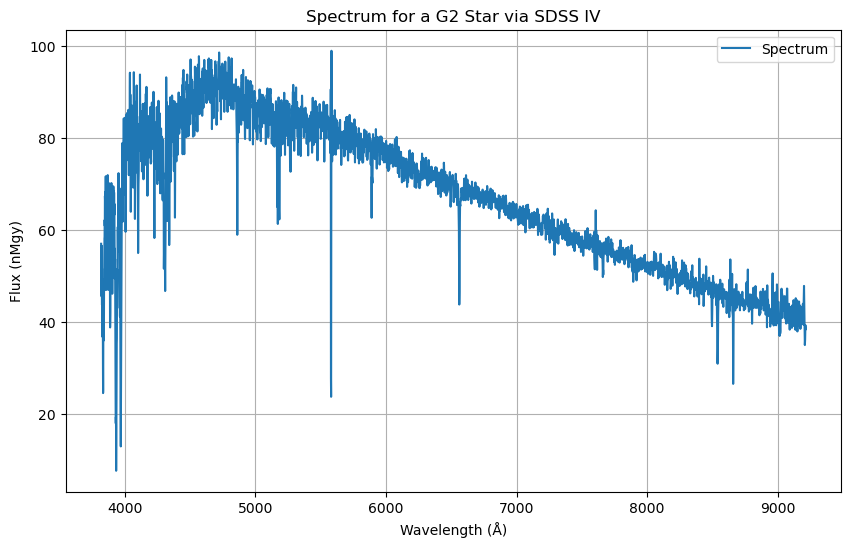

In [126]:
fits_file = './example.fits'
def open_fits(fits_file):
    """
    Opens a FITS file based off of user input, extracts spectrum data, and plots it.
    If spectrum data is not in the correct format an error will occur
    some good examples can be found here: https://data.sdss.org/sas/dr18/spectro/sdss/redux/v6_0_4/spectra/full/15166p/59251/
    simply download the fits file and input path name when prompted
    """

    try:
        with fits.open(fits_file) as hdul:
            # Display information about the FITS file (helps in debugging)
            print(f"FITS File Info:\n")
            hdul.info()

            # Assuming data is in the second HDU (index 1), but we should check the exact structure
            data = hdul[1].data
            data2=hdul[2].data

            # Print the column names to ensure correct data access
            print(f"\nColumns in the FITS data hdul[1]: {data.columns.names}")
            print(f"\nColumns in the FITS data hdul[2]: {data2.columns.names}")
            
            # Check if 'loglam' and 'flux' exist in the columns
            if 'loglam' in data.columns.names and 'flux' in data.columns.names and 'Z' in data2.columns.names:
                wavelength = 10 ** data['loglam']  # Convert log(wavelength) to wavelength (Å)
                flux = data['flux']
                redshift=data2['Z']
                ivar=data['ivar']
            else:
                raise ValueError("Required columns ('loglam', 'flux') not found in the FITS file.")  

            return data, data2, wavelength, flux, redshift, ivar

    except FileNotFoundError:
        print(f"Error: File '{fits_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

#Set global variables from fits file
    
data, data2, wavelength, flux, redshift, ivar= open_fits(fits_file) 

#Plot full specturm
def plot_full_spectrum(wavelength,flux):
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength, flux, label="Spectrum")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux (nMgy)")
    plt.title(f"Spectrum for a G2 Star via SDSS IV")
    plt.legend()
    plt.grid()
    plt.show()

 # Call the function to process the FITS file
plot_full_spectrum(wavelength,flux)

Let's truncate our spectrum around the h-alpha line some where around 6562 Angstroms, and account for the redshift given in our spectra

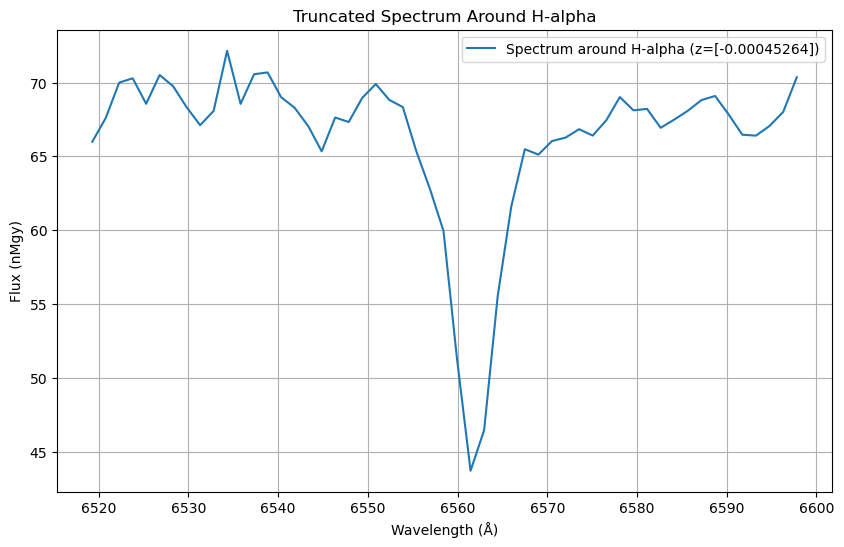

In [127]:
#Need to account for a redshift
# print(redshift)
# print(ivar)

h_alpha_obs=6562*(1+redshift)
delta=40 #Angstroms

lower=h_alpha_obs-delta
upper=h_alpha_obs+delta


# Truncate the data around H-alpha
mask = (wavelength >= lower) & (wavelength <= upper)
truncated_wavelength = wavelength[mask]
truncated_flux = flux[mask]

plt.figure(figsize=(10, 6))
plt.plot(truncated_wavelength, truncated_flux, label=f"Spectrum around H-alpha (z={redshift})")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (nMgy)")
plt.title("Truncated Spectrum Around H-alpha")
plt.legend()
plt.grid()
plt.show()

We will come back to the spectrum later, for now let's work on implementing MCMC on simulated data, utilizing the package "emcee".

PART 2: Implementing MCMC via emcee on simulted data!

First, let's create some Gaussian like data with some noise. Run the next cell to plot "fake data" and the "true" model. Spectral lines often look Lorentzian as well, so let's also code in a Lorentzian model to compare!

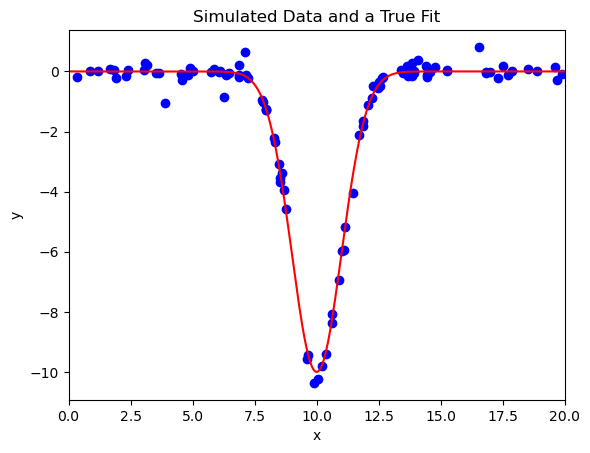

In [128]:
#set a random seed
np.random.seed(123)

N=100
x=np.sort(20*np.random.rand(N))
x0=np.linspace(0,20,500)
yerr=.5*np.random.rand(N)

#"True" parameters to create model and simulated data
width=1.0
a=-10
mu=10

def gauss_model(x, mu, sigma_gauss, a):
     return a*np.exp(-1/2*((x-mu)/sigma_gauss)**2)

def lorentz_model(x, mu, gamma, a):
    return  a / (1 + ((x - mu) / gamma) ** 2)

def fake_data(x, mu, sigma_gauss, a, yerr):
    y=gauss_model(x, mu, sigma_gauss,a )
    y_noisy= y + np.random.normal(0, yerr, size=(len(x)))
    return y_noisy

y_true=gauss_model(x0,mu,width,a)
fake=fake_data(x, mu, width, a, yerr)

#Plot model and noisy data

plt.plot(x0,y_true, label="true model", color="red")
plt.scatter(x,fake,label="Simulated Data", color= "blue")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Simulated Data and a True Fit")
plt.xlim(0,20);

For now, would you like to do a Gaussian or Lorentzian fit? Run the next cell, type in your choice and click enter

In [129]:
first_choice=input("Please choose a model MCMC will fit, either 'gauss' or 'lorentz' " )
if first_choice not in ["gauss", "lorentz"]:
    raise ValueError("Please rerun cell and input either 'gauss' or 'lorenzt'.")

Now we can start setting up our MCMC, we need three functions: a log likelihood function, a prior, and the overall probablity function. These are all statistical functions based on Bayesian Inference. To learn more about each of these functions, the tutorial for emcee has a lovely explanation! Using log functions allows us to simplify the process a bit and stears us away from running into rounding, or computer memory based errors.


These functions will take into account whether we will be using a Lorentzian or Gaussian model

In [130]:


#Log Likelihood function 
def log_likelihood(theta,x,y, yerr,model):
     
    if model == "gauss":
        mu, sigma, a = theta
        model=gauss_model(x, mu, sigma, a)

    elif model == "lorentz": 
        mu, gamma, a = theta
        model=lorentz_model(x, mu, gamma, a)
    else:
        raise ValueError("Model must be 'gauss' or 'lorentz'.")

    sigma2 = 2*np.pi*yerr**2

    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#Prior, adjust these if needed to something more physical
def log_prior(theta,model):
    
    if model == "gauss":
        mu, sigma_gauss, a = theta
        if -1000 < mu < 7000 and 0 < sigma_gauss < 10.0 and -1000 < a < 0 :
            return 0.0

    elif model == "lorentz": 
        mu, gamma, a = theta
        if 0 < mu < 7000 and 0 < gamma < 100 and -50 < a < 0 :
            return 0.0
    return -np.inf


#Total Probability
def log_probability(theta, x, y, yerr, model):  #full probability including log_liklihood and log_prior functions
    lp=log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,x, y, yerr, model)

To make sure we have a really solid initial position for the MCMC, let's minimize our likelihood function to maximize the probability of our parameters.

Note: The optimized parameters for a Lorentzian should be "worse" than the Gaussian since we used a Gaussian function to create our fake data, feel free to rerun the input cell with both models and compare the corresponding results

In [131]:
np.random.seed(50)
nll=lambda *args: -log_likelihood(*args)
initial = np.array( [mu, width, a ] ) + 0.1*np.random.randn(3)
soln=minimize(nll, initial, args=(x, fake, yerr, first_choice))
mu, width, a = soln.x

#Print out results, compare to known parameters to ensure close but not exact match
print("Maximum Likelihood using Scipy Optimize: ")
print(f'mu= ', mu)
if first_choice=="gauss":
    print(f'sigma_gauss= ', width)
elif first_choice=="lorentz":
    print(f'gamma', width)
print(f'a=', a)

Maximum Likelihood using Scipy Optimize: 
mu=  10.005618296655731
sigma_gauss=  1.0041619822762473
a= -10.018376446519643


Now that we have confirmed an "optimal" position for our walkers to start in we will place them in those positions with a little bit of noise to make sure they will fully explore the parameter space and run emcee, feel free to change the 32 to maybe 50 or 60 to add more walkers to explore the parameter space!

It is possible to run emcee with any initial position, I found minimizing the likelihood function allowed an extra security measure to ensure your walkers have a reasonable starting position, will ensure convergence, and will decrease the amount of time it takes for your walkers to converge. Basically this increases the efficiency and reliability of the MCMC!

Walkers, on your marks...get set... go!

In [132]:
#Adjust for the number of walkers and steps you would like to have! Reccomended is at least 32 walkers and 5000 steps

walkers=32
steps=5000

In [133]:
pos=soln.x +1e-4*np.random.rand(walkers,3) #random walkers in 3 dimensions, updated dim if needed
nwalkers, ndim= pos.shape

sampler=emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, fake, yerr, first_choice))

#Change 5000 to your desired amount of steps you would like your walkers to take
sampler.run_mcmc(pos, steps, progress=True);

100%|██████████| 5000/5000 [00:01<00:00, 2561.58it/s]


Now, let's visualize each of our parameters and all of the walkers to ensure they did all converge

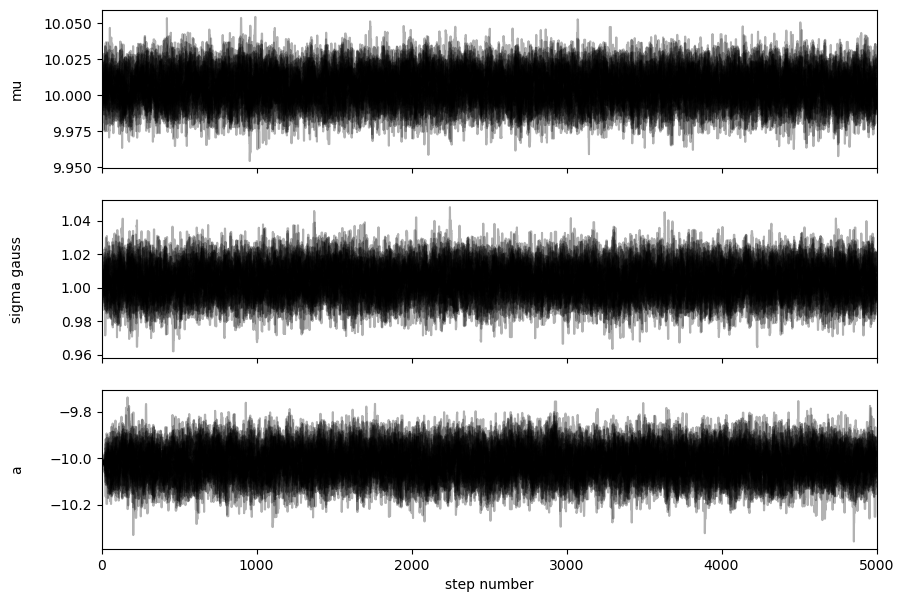

In [134]:
fig, axs= plt.subplots(3, figsize=(10,7), sharex=True)
samples = sampler.get_chain()

if first_choice=="gauss":
    labels= ["mu", "sigma gauss", "a"]
elif first_choice=="lorentz":
    labels= ["mu", "gamma", "a"]


for i in range(ndim):
    ax= axs[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)

axs[-1].set_xlabel("step number");

If this plot looks absolutley insane, there are rogue lines, or entirely black... your walkers went bushwacking in different directions and did not converge. Stop here to trouble shoot if needed. Below are some lines to uncomment if you need. None of your functions should be outputing "-inf", if you are these are the functions you need to trouble shoot. 

For example, for a while my prior was returning -inf. Turns out the bounds I set for my amplituted "a" were completely incorrect, I set my prior to filter out negative values instead of positive!

In [135]:
# print(log_probability(soln_spec.x, truncated_wavelength, truncated_flux, yerr_data, model_choice))
# perturbed = soln_spec.x + [0.1, 0.1, 0.1, 0.1]
# print(log_probability(perturbed, truncated_wavelength, truncated_flux, yerr_data, model_choice))
# print("Parameters:", perturbed)
# print("Prior:", log_prior(perturbed, model_choice))
# print("Likelihood:", log_likelihood(perturbed, truncated_wavelength, truncated_flux, yerr_data, model_choice))

If the plot above looks all good, let's investigate how long it actually took to converge. It is a bit difficult to determine this visually. The line below essentially tells us how long each chain takes to forget its initial state, a shorter autocorr time tells us the chain is "mixing" well and exploring the parameter space effectively

In [136]:
tau=sampler.get_autocorr_time() 
print(f'Autocorrelation time (mu, sigma/gamma, a): ', tau)

Autocorrelation time (mu, sigma/gamma, a):  [34.79266755 37.26652301 38.68063055]


For a safe bet, let's get rid of the first 100 steps to ensure we are only plotting after the walkers converged and make a corner plot with our results!

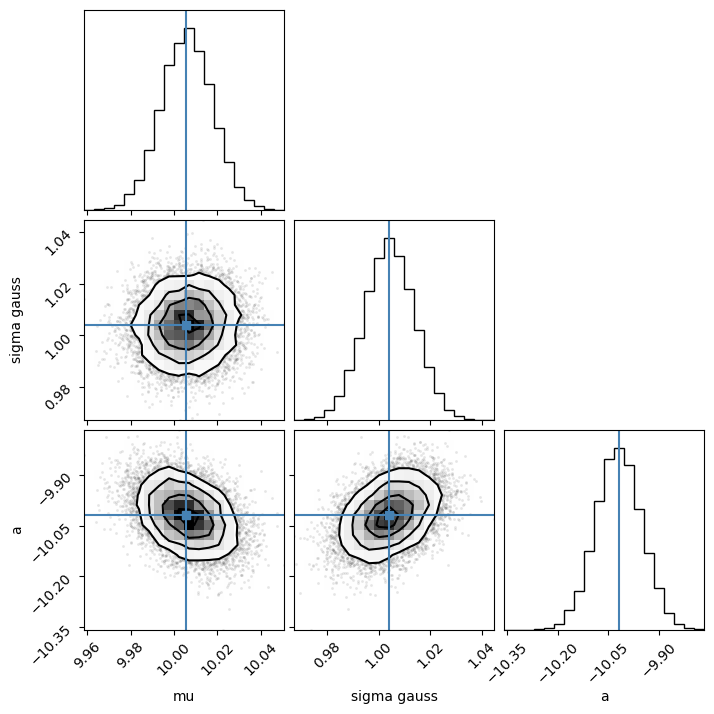

In [137]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig= corner.corner(flat_samples, labels=labels, truths=[mu, width, a])

The blue bullseye should roughly lie in the center of each of the circles. Finally, let's plot our final results over our initial data, and "true" model.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

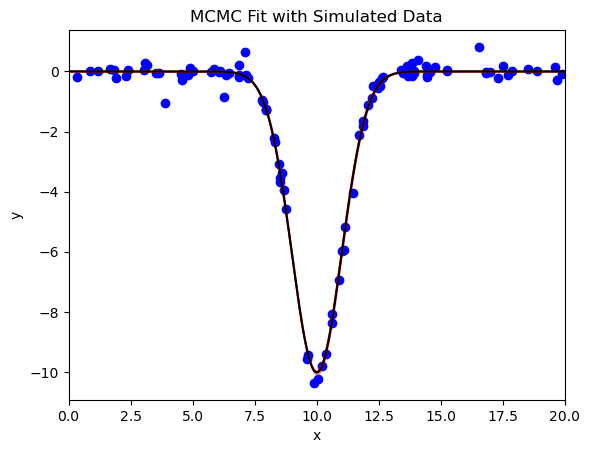

In [138]:
#This displays our results and uncertainties in Latex format so we can succinctly see what we get
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt=r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}" 
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]) 
    display(Math(txt)) 

#Plot these results
n_samples=500
sampled=[]
for sample in flat_samples[np.random.randint(len(flat_samples), size=n_samples)]:
    mu, width, amplitude = sample  # Extract parameter values
    if first_choice=="gauss":
        sampled.append(gauss_model(x0, mu, width, amplitude))
    elif first_choice=="lorentz":
        sampled.append(lorentz_model(x0, mu, width, amplitude))

sampled = np.array(sampled)
median_model = np.median(sampled, axis=0)
lower_band = np.percentile(sampled, 16, axis=0)
upper_band = np.percentile(sampled, 84, axis=0)

plt.plot(x0,y_true, label="true model", color="red")
plt.scatter(x,fake,label="Simulated Data", color= "blue")
plt.plot(x0,median_model, label="Mean Model", color="black")
plt.fill_between(x0, lower_band, upper_band, color="red", alpha=0.3, label="1-sigma uncertainty")
plt.xlabel("x")
plt.ylabel("y")
plt.title("MCMC Fit with Simulated Data")
plt.xlim(0,20);

Woohoo! Now we know our MCMC works and we have some practice, let's apply this same process to our data! We will need to add an extra parameter becuase the real data has a vertical offset that we need to take into account. Let's redefine our functions to take this into account.

In [139]:
#As a reminder the variables we will need are our flux, wavelength, and error on our flux from our SDSS data
#truncated_wavelength = wavelength[mask]
#truncated_flux = flux[mask]
#ivar


# Observational error is given as an inverse variance
avg_yerr=np.mean(1/np.sqrt(ivar))
yerr_data= np.full_like(truncated_flux, avg_yerr) #applies an average yerr to all flux data

#Define Gaussian and Lorentz equations
def gauss_model(x, mu, sigma_gauss, a, offset):
     return a*np.exp(-1/2*((x-mu)/sigma_gauss)**2) + offset

def lorentz_model(x, mu, gamma, a, offset):
    return  a / (1 + ((x - mu) / gamma) ** 2) + offset


#Update functions needed in MCMC to allow a vertical offset, this will add a 4 parameter (dimension)

#Log Likelihood function (posterior)
def log_likelihood(theta, x, y, yerr,model):
     
    if model == "gauss":
        mu, sigma, a, offset = theta
        model=gauss_model(x, mu, sigma, a, offset)

    elif model == "lorentz": 
        mu, gamma, a, offset = theta
        model=lorentz_model(x, mu, gamma, a, offset)
    else:
        raise ValueError("Model must be 'gauss' or 'lorentz'.")

    sigma2 = 2*np.pi*yerr**2

    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#Prior
def log_prior(theta,model):
    
    if model == "gauss":
        mu, sigma_gauss, a, offset = theta
        if -1000 < mu < 7000 and 0 < sigma_gauss < 10.0 and -1000 < a < 0 and 0<offset<1000:
            return 0.0

    elif model == "lorentz": 
        mu, gamma, a, offset = theta
        if 0 < mu < 7000 and 0 < gamma < 10 and -50 < a < 0 and 0<offset<1000 :
            return 0.0
    return -np.inf


#Total Probability
def log_probability(theta, x, y, yerr, model):  #full probability including log_liklihood and log_prior functions
    lp=log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,x, y, yerr, model)


For this iteration, would we like to apply a Gaussian or Lorentzian to our spectrum?

In [140]:
model_choice=input("Please choose a model MCMC will fit, either 'gauss' or 'lorentz' " )
if model_choice not in ["gauss", "lorentz"]:
    raise ValueError("Please rerun cell and input either 'gauss' or 'lorentz'.")

Again, we shall minimize our likelhood function with a tiny bit of noise to find a trustworth starting point for the MCMC

In [141]:
nll_spec = lambda *args: -log_likelihood(*args)
#Initial guesses for mu, width, a, and the vertical offset
initial_spec = np.array([np.mean(truncated_wavelength), 1.5, truncated_flux.min()-truncated_flux.max(), np.mean(truncated_flux)]) + 0.1 * np.random.randn(4)
soln_spec = minimize(nll_spec, initial_spec, args=(truncated_wavelength, truncated_flux, yerr_data, model_choice))
mu_opt, width_opt, a_opt , c_opt= soln_spec.x

# Results
print("Maximum Likelihood using Scipy Optimize:")
print(f"mu = {mu_opt:.3f}")
print(f"width = {width_opt:.3f}")
print(f"a = {a_opt:.3f}")
print(f"vertical offset = {c_opt:.3f}")

Maximum Likelihood using Scipy Optimize:
mu = 6558.326
width = 1.601
a = -28.369
vertical offset = 66.286


For this portion of the spectrum if this does not give around mu=6560, width = 2, a=-20, and vertical offset= 65 something has gone wrong, uncomment the lines below to confirm your functions are behaving as expected. As a reminder, if there are any -inf your functions are telling you something is wrong!

In [142]:
# print(log_probability(soln_spec.x, truncated_wavelength, truncated_flux, yerr_data, model_choice))
# perturbed = soln_spec.x + [0.1, 0.1, 0.1, 0.1]
# print(log_probability(perturbed, truncated_wavelength, truncated_flux, yerr_data, model_choice))
# print("Parameters:", perturbed)
# print("Prior:", log_prior(perturbed, model_choice))
# print("Likelihood:", log_likelihood(perturbed, truncated_wavelength, truncated_flux, yerr_data, model_choice))

If all is good, implement MCMC with your desired amount of walkers in 4 dimensions. Using 50 walkers going 10,000 steps, this chain will take about 10 seconds

In [143]:
walkers=50
steps=10000


100%|██████████| 10000/10000 [00:07<00:00, 1296.21it/s]


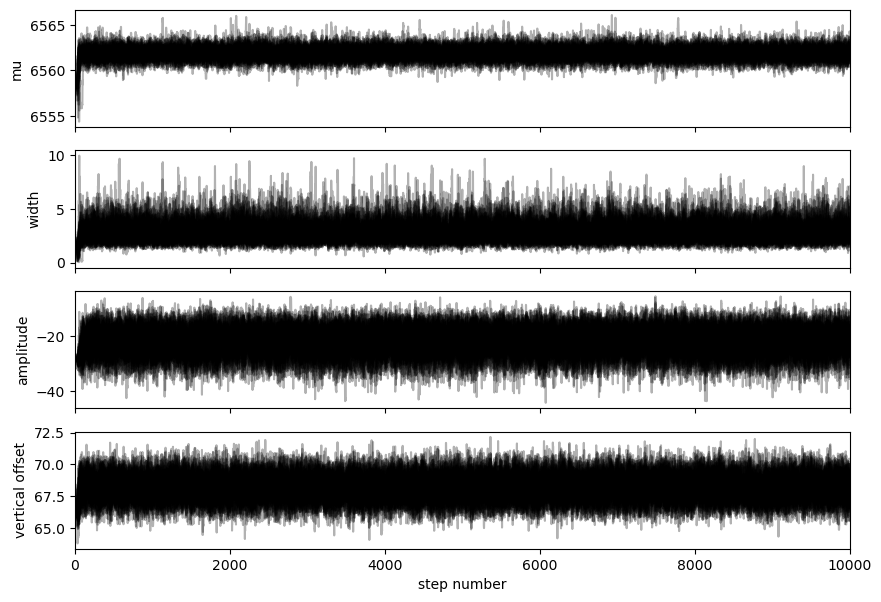

In [144]:
pos_spec=soln_spec.x +1e-4*np.random.rand(walkers,4) #random walkers in 4 dimensions, updated dim if needed
nwalkers, ndim= pos_spec.shape

sampler_data=emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(truncated_wavelength, truncated_flux, yerr_data, model_choice))
sampler_data.run_mcmc(pos_spec, steps, progress=True); 

#Plot walkers in all parameter spaces

fig, axs= plt.subplots(4, figsize=(10,7), sharex=True)
samples_data = sampler_data.get_chain() 
labels= ["mu", "width", "amplitude", "vertical offset"]
for i in range(ndim):
    ax= axs[i]
    ax.plot(samples_data[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_data))
    ax.set_ylabel(labels[i])
   

axs[-1].set_xlabel("step number");

Let's further visualize the parameter space and confirm expected correleations

[47.65347631 48.80396708 45.99791646 46.35596061]


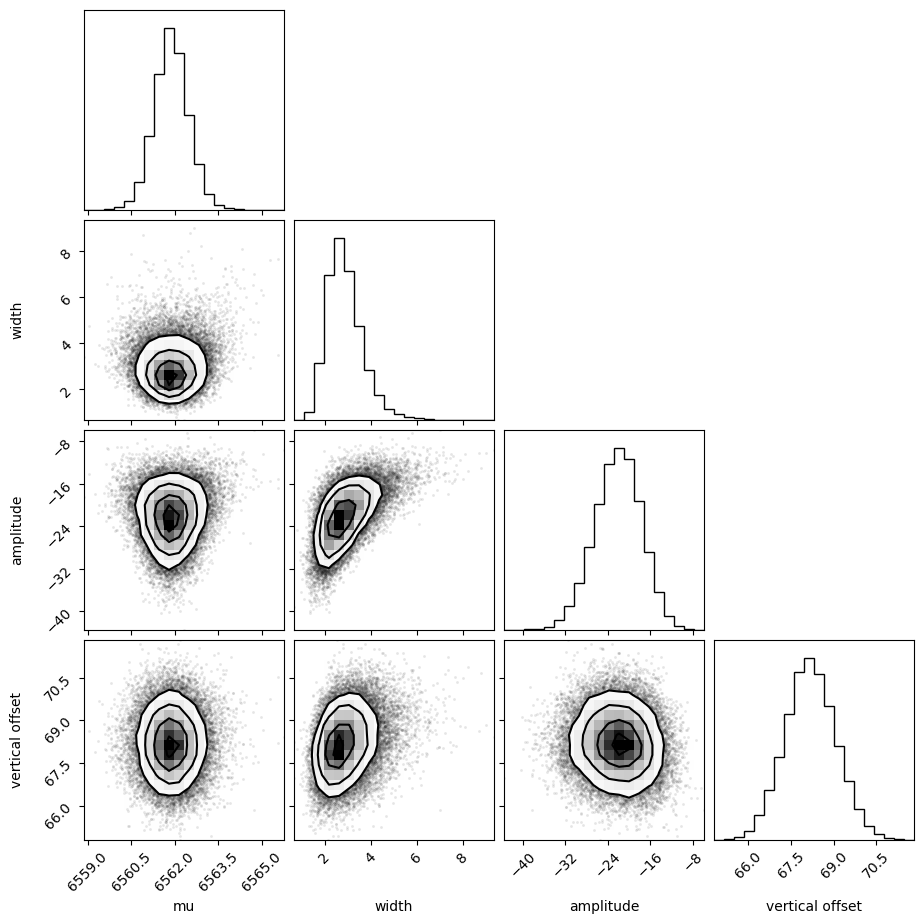

In [145]:
tau_data=sampler_data.get_autocorr_time()
print(tau_data) 

flat_samples_data = sampler_data.get_chain(discard=100, thin=15, flat=True)
#print(flat_samples_data.shape)

fig_data= corner.corner(flat_samples_data, labels=labels)

And lastly, let's plot our model with uncertainty over our data to confirm we found a decent fit!

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/9m/9m_5sjqd0w70mczqwldr0qn40000gn/T/ipykernel_53406/2099270737.py:5: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

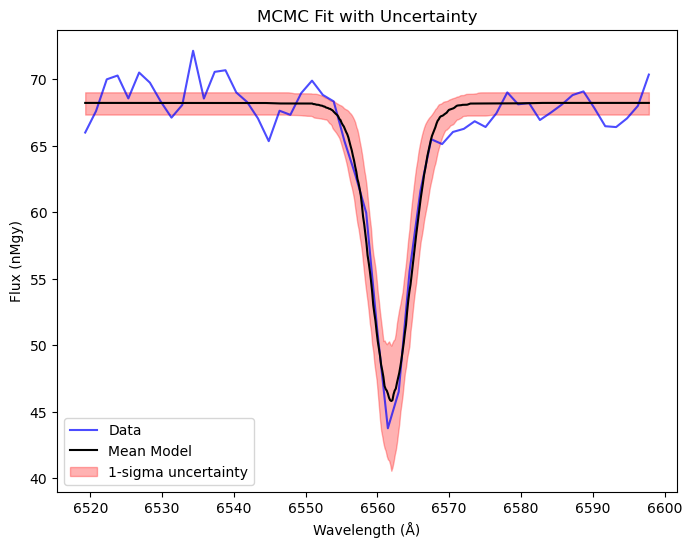

In [147]:
#Show results in Latex like format
for i in range(ndim):
    mcmc = np.percentile(flat_samples_data[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

# Generate multiple realizations of the model using MCMC samples
n_samples = 100  # Number of samples to use for uncertainty visualization
sampled_models = []
x_range = np.linspace(truncated_wavelength.min(), truncated_wavelength.max(), 500)

for sample in flat_samples_data[np.random.randint(len(flat_samples), size=n_samples)]:
    mu, sigma, amplitude, offset = sample  # Extract parameter values
    sampled_models.append(gauss_model(x_range, mu, sigma, amplitude, offset))

sampled_models = np.array(sampled_models)

# Compute the mean model and uncertainty bands
median_model = np.median(sampled_models, axis=0)
lower_band = np.percentile(sampled_models, 16, axis=0)
upper_band = np.percentile(sampled_models, 84, axis=0)

# Plotting the data, mean model, and uncertainty
plt.figure(figsize=(8, 6))
plt.plot(truncated_wavelength, truncated_flux, label="Data", color="blue", alpha=0.7)
plt.plot(x_range, median_model, label="Mean Model", color="black")
plt.fill_between(x_range, lower_band, upper_band, color="red", alpha=0.3, label="1-sigma uncertainty")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux (nMgy)")
plt.title("MCMC Fit with Uncertainty")
plt.legend()
plt.show()


Please note: the "Width" parameter is used to describe sigma for a Guassian, and gamma for Lorentzian. Though they are both related to the width of the curve they are different, for ease of coding they were treated similarly in the parameter space.

This concludes the tutorial of implementing emcee on an example spectra from SDSS-IV!
